In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim, ylim):
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(16) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(16) 
        
        return x_ax, y_ax
####################################### Plotting Function

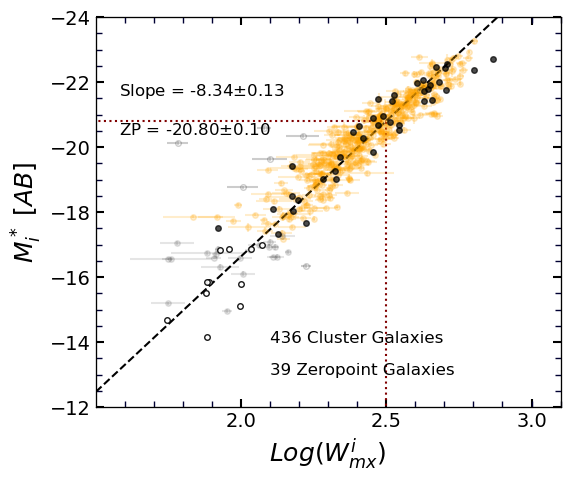

In [3]:
########### Updated list using the color-LogWimx correltion
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

band = 'i'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                            band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True)

In [4]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]


key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo  = myCluster['zp']

MAG       = myCluster['mag']-zp_virgo+zp
MAG_w     = myCluster['mag_w']-zp_virgo+zp
logWimx   = myCluster['logWimx']
logWimx_w = myCluster['logWimx_w']
logWimx_e = myCluster['logWimx_e']
pgc       = myCluster['pgc']
pgc_w     = myCluster['pgc_w']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        
        MAG       = np.concatenate((MAG, myCluster['mag']-zp_+zp))
        MAG_w     = np.concatenate((MAG_w, myCluster['mag_w']-zp_+zp))
        logWimx   = np.concatenate((logWimx, myCluster['logWimx']))
        logWimx_w = np.concatenate((logWimx_w, myCluster['logWimx_w']))
        logWimx_e = np.concatenate((logWimx_e, myCluster['logWimx_e']))
        pgc       =  np.concatenate((pgc, myCluster['pgc']))
        pgc_w     =  np.concatenate((pgc, myCluster['pgc_w']))


indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in I_maglim:
        indx.append(i)
    else:
        indx_.append(i) # faint

        
MAG_faint       = []
logWimx_faint   = []
pgc_faint       = []

if len(indx_)>0:
    MAG_faint       = MAG[indx_]
    logWimx_faint   = logWimx[indx_]
    pgc_faint       = pgc[indx_]

if len(indx)>0:
    MAG       = MAG[indx]
    logWimx   = logWimx[indx]
    logWimx_e = logWimx_e[indx]
    pgc       = pgc[indx]

    
delta = MAG - (slope*(logWimx-2.5)+zp)
delta_e = np.sqrt(0.05**2+(slope_e*(logWimx-2.5))**2+(slope*logWimx_e)**2+zp_e**2)

In [5]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

N = len(pgc)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in subtract


In [6]:
P1_w1 = -0.7071*(mu50_w1-22.83)/1.45+0.7071*(m21_w1-2.08)/1.34
P1_w2 = -0.7071*(mu50_w2-23.42)/1.61+0.7071*(m21_w2-1.51)/1.44

D_i_w1 = i_w1-  (1.18*(logWimx-2.5)-0.47)
D_mu50_i = mu50_i-   (-3.12*(logWimx-2.5)+22.48)
D_m21_i = m21_i-   (2.56*(logWimx-2.5)+2.36)
D_g_i = g_i-   (0.84*(logWimx-2.5)+0.64)





print len(delta), len(SSqlt), len(logWimx)

436 436 436


In [7]:
def correlation(A, B):
    

    
    data = {'A':A, 'B':B}
    d = pd.DataFrame.from_dict(data)
    corr = d.corr()
    
    return 100.*np.abs(corr['A']['B'])

0.28$\pm$0.08 & 0.14$\pm$0.05 & 12
-0.02$\pm$0.02 & 0.37$\pm$0.41 & 1
0.02$\pm$0.02 & -0.04$\pm$0.06 & 1
0.29$\pm$0.10 & -0.18$\pm$0.06 & 14


Text(-0.06,-2.59,'C = 14%')

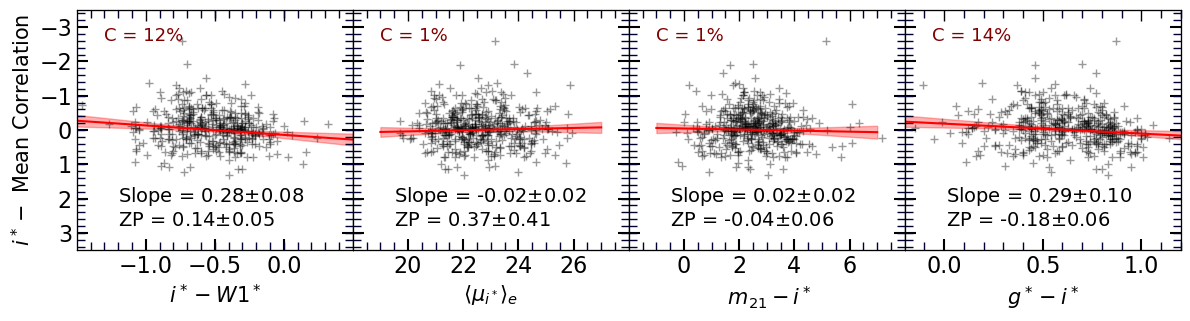

In [8]:
fig = py.figure(figsize=(12, 3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 4) ; p=0
ylim=[3.5,-3.5]

indx, = np.where((SSqlt>=2) & (WWqlt>=2))
Y = delta[indx]
Ye = delta_e[indx]
X = i_w1[indx]
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-1.5,0.5,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-1, 0.5, step=0.5))
Xlm = [-1.5,0.5]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-1, 0.5, step=0.5))
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_ylabel(r'$i^*-$'+' Mean Correlation', fontsize=15)
ax.set_xlabel(r'$ i^*-W1^* $', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

Y = delta
Ye = delta_e
X = mu50_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(19,27,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(20,28, step=2))
Xlm = [18,28]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(20,28, step=2))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$ \langle\mu_{i^*}\rangle_e $', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

Y = delta
Ye = delta_e
X = m21_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-1,7,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(0,8, step=2))
Xlm = [-2,8]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(0,8, step=2))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\ m_{21}-i^* $', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')


Y = delta
Ye = delta_e
X = g_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-3,4,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(0, 1.5, step=0.5))
Xlm = [-0.2,1.2]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(0,1.5, step=0.5))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$ g^*-i^* $', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

-0.24$\pm$0.11 & -0.00$\pm$0.02 & 26
0.06$\pm$0.02 & -0.02$\pm$0.02 & 24
-0.06$\pm$0.02 & 0.01$\pm$0.02 & 18
-0.31$\pm$0.14 & -0.00$\pm$0.02 & 19


Text(-0.56,-2.59,'C = 19%')

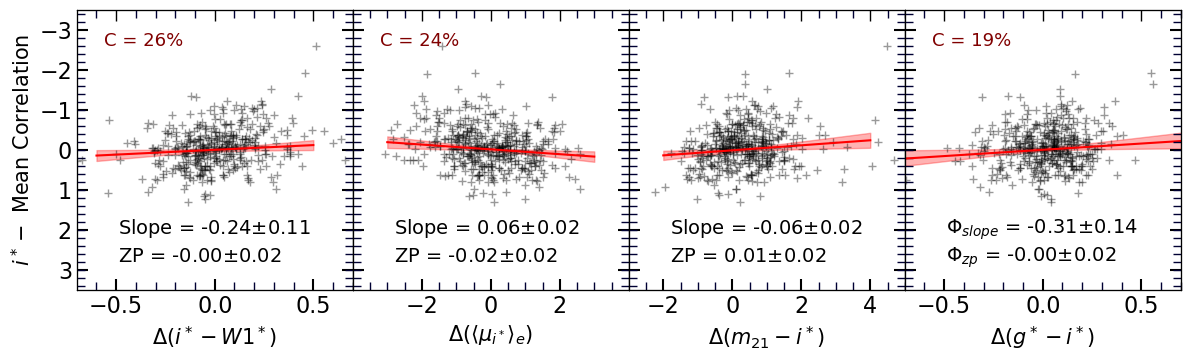

In [9]:
fig = py.figure(figsize=(12, 3.5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 4) ; p=0
ylim=[3.5,-3.5]

indx, = np.where((SSqlt>=2) & (WWqlt>=2))
Y = delta[indx]
Ye = delta_e[indx]
X = D_i_w1[indx]
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
# ax.errorbar(X,Y, yerr=Ye, fmt='.', color='k', alpha=0.2)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-0.6,0.5,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-0.5, 1, step=0.5))
Xlm = [-0.7,0.7]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-0.5, 1, step=0.5))
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_ylabel(r'$i^*-$'+' Mean Correlation', fontsize=15)
ax.set_xlabel(r'$\Delta ( i^*-W1^* )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

Y = delta
Ye = delta_e
X = D_mu50_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-3,3,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-2, 4, step=2))
Xlm = [-4,4]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-2, 4, step=2))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\Delta ( \langle\mu_{i^*}\rangle_e )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

Y = delta
Ye = delta_e
X = D_m21_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-2,4,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-2, 5, step=2))
Xlm = [-3,5]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-2, 5, step=2))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\Delta ( m_{21}-i^* )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)



Y = delta
Ye = delta_e
X = D_g_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-3,4,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-0.5, 1, step=0.5))
Xlm = [-0.7,0.7]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-0.5, 1, step=0.5))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, r"$\Phi_{slope}$"+" = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$\Phi_{zp}$"+" = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\Delta ( g^*-i^* )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

0.00$\pm$0.00 & -0.13$\pm$0.16 & 14


Text(46,-2.59,'C = 14%')

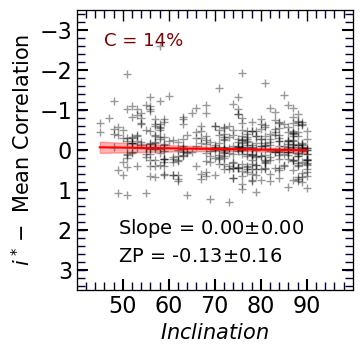

In [10]:
fig = py.figure(figsize=(12, 3.5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 4) ; p=0
ylim=[3.5,-3.5]


Y = delta
Ye = delta_e
X = inc
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(45,90,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(50,100, step=10))
Xlm = [40,100]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(50,100, step=10))
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$Inclination$', fontsize=15)
ax.set_ylabel(r'$i^*-$'+' Mean Correlation', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')

0.06$\pm$0.02 & -0.02$\pm$0.02 & 24
-0.24$\pm$0.11 & -0.00$\pm$0.02 & 26


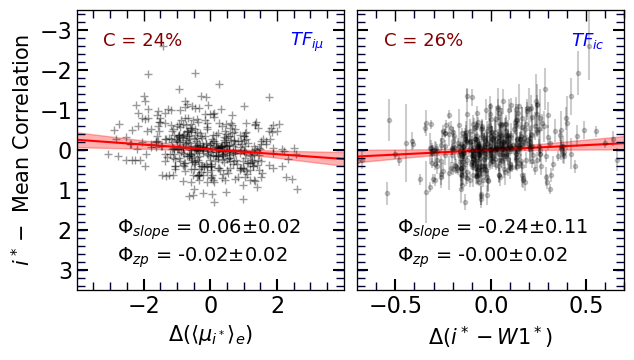

In [16]:
fig = py.figure(figsize=(9, 3.5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 3) ; p=0
ylim=[3.5,-3.5]



Y = delta
Ye = delta_e
X = D_mu50_i
ax = plt.subplot(gs[p]) ; p+=1
ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-4,4,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-2, 4, step=2))
Xlm = [-4,4]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-2, 4, step=2))
# plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, r"$\Phi_{slope}$"+" = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$\Phi_{zp}$"+" = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\Delta ( \langle\mu_{i^*}\rangle_e )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
ax.set_ylabel(r'$i^*-$'+' Mean Correlation', fontsize=15)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')
x0 = 0.2*Xlm[0]+0.8*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, r"$TF_{i \mu }$", fontsize=13, color='blue')


indx, = np.where((SSqlt>=2) & (WWqlt>=2))
Y = delta[indx]
Ye = delta_e[indx]
X = D_i_w1[indx]
ax = plt.subplot(gs[p]) ; p+=1
ax.errorbar(X,Y, yerr=Ye, fmt='.', color='black', alpha=0.2)
# ax.plot(X,Y, '+', color='black', alpha=0.4)
fit, cov = curve_fit(linfit, X, Y, sigma=Ye)
sl,zp = fit
x0 = np.linspace(-3,4,50)
y0 = sl*x0+zp
ax.plot(x0, y0, 'r-')
me = np.sqrt(cov[0,0])
be = np.sqrt(cov[1,1])
mbe = cov[1,0]
dy = np.sqrt(x0**2*me**2+be**2+2*x0*mbe)
ax.fill_between(x0, y0+2*dy, y0-2*dy, color='r', alpha=0.3)
ax.set_xticks(np.arange(-0.5, 1, step=0.5))
Xlm = [-0.7,0.7]
x_ax, y_ax = set_axes(ax, Xlm, ylim)
x_ax.set_xticks(np.arange(-0.5, 1, step=0.5))
plt.setp(ax.get_yticklabels(), visible=False) 
Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.8*Ylm[0]+0.20*Ylm[1]
ax.text(x0,y0, r"$\Phi_{slope}$"+" = "+"%.2f" % sl+'$\pm$'+"%.2f" % me, fontsize=14, color='k')
y0 = 0.9*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$\Phi_{zp}$"+" = "+"%.2f" % zp+'$\pm$'+"%.2f" % be, fontsize=14, color='k')
ax.set_xlabel(r'$\Delta ( i^*-W1^* )$', fontsize=15)
print '%.2f'%sl+r'$\pm$'+'%.2f'%me+' & '+'%.2f'%zp+r'$\pm$'+'%.2f'%be+' & '+ '%d'%correlation(X, Y)
x0 = 0.9*Xlm[0]+0.10*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, "C = %d"%correlation(X, Y)+ '%', fontsize=13, color='maroon')
x0 = 0.2*Xlm[0]+0.8*Xlm[1]
y0 = 0.13*Ylm[0]+0.87*Ylm[1]
ax.text(x0,y0, r"$TF_{ic}$", fontsize=13, color='blue')





plt.subplots_adjust(hspace=.0, wspace=0.05)